In [1]:
# Importing packages
using Lux
using Zygote
using Optimization
using OptimizationOptimisers
using Random
using Statistics
using DifferentialEquations
using Plots
using ComponentArrays
using NNlib

## The goal is to identify unknown ODE parameters and partial ODE equation components themselves using MLPs

The following equations will be used to generate the noisy data. These equations are a classic SIR model:

$ \frac{d}{dt}S = -\beta S $

$ \frac{d}{dt}I = \beta S - \gamma I $

$ \frac{d}{dt}R = + \gamma I $

There will be log-normal noise added to simulate a real world scenario

In [2]:
struct SIR_params
    β::Float32
    γ::Float32
end

# SIR model method for DifferentialEquations call 
function SIR_model!(du, u, p::SIR_params, t)
    S, I, R = u
    du[1] = -p.β * S * I 
    du[2] =  p.β * S * I - p.γ * I
    du[3] =  p.γ * I
end

# SIR model non mutating function method to calculate NN RHS
# This is another way to define a function
SIR_model(y::AbstractMatrix{<:Real}, p::SIR_params) = begin

    dS = - p.β .* y[1, :] .* y[2, :]        
    dI = p.β .* y[1,:] .* y[2, :] - p.γ .* y[2, :]
    dR = p.γ .* y[2, :]                         
    permutedims(hcat(dS, dI, dR))
end

# For a non-matrix input 
SIR_model(y::AbstractVector{<:Real}, p::SIR_params) = begin

    dS = - p.β .* y[1] .* y[2]        
    dI = p.β .* y[1] .* y[2] - p.γ .* y[2]
    dR = p.γ .* y[2]                         
    permutedims(hcat(dS, dI, dR))
end

function SIR_model(y::AbstractVecOrMat{<:Real}, p::SIR_params, gPred::AbstractVector{<:Real})
    # g has to be an output of g_MLP(t, θ_g) predictions
    dS = gPred
    dI = p.β .* y[1] .* y[2] - p.γ .* y[2]
    dR = p.γ .* y[2]                         
    permutedims(hcat(dS, dI, dR))
end

# Fast default RNG. Does not get messed up with a global RNG
rng = Random.MersenneTwister(42)

# Start with our true known parameters
true_SIR_par = SIR_params(0.30, 0.1)
t_span = (0.0f0, 60.0f0)
N_obs = 101

# Collect seems to turn an iterable into an array
t_obs_array = range(t_span[1], t_span[2], length=N_obs) |> collect
u0 = [0.999, 0.001, 0.0]

# solve the ODE to get a solution object
prob = DifferentialEquations.ODEProblem(SIR_model!, u0, t_span, true_SIR_par)
sol = DifferentialEquations.solve(
    prob,
    DifferentialEquations.Tsit5();
    saveat = t_obs_array
)
# Convert the solution object into an Array
sol_ = Array(sol)

# multiplicative % noise via lognormal, unbiased & positive 
noise_pct = 0.2
ε = Random.randn(rng, size(sol_)...)
noisy_data = sol_ .* exp.(noise_pct .* ε .- 0.5 * noise_pct^2) 
noisy_data = clamp.(noisy_data, 0, Inf32)

# Convert to Float32 to keep everyone happy
t_train = Float32.(t_obs_array)
Y_train = Float32.(noisy_data)
y0_obs  = sol_[:, 1]     # IC for penalty

Y_train_std = Statistics.std(Y_train, dims=2);


### Visualize the generated data

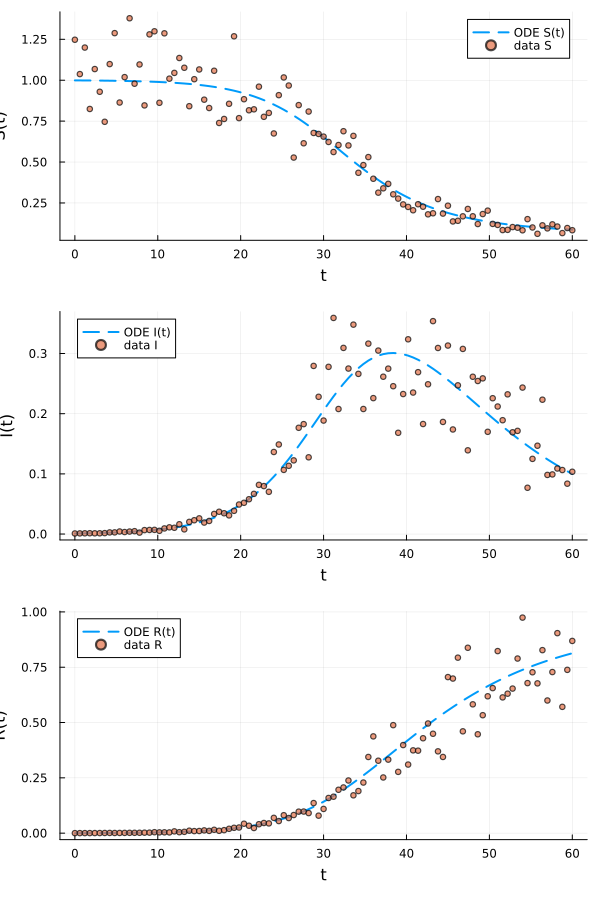

In [3]:

# A smooth time grid for plotting the NN curve
t_plot = Float32.(collect(range(t_span[1], t_span[2], length=400)))


# Split true, NN, and noisy series
S_true, I_true, R_true = sol_[1, :], sol_[2, :], sol_[3, :]
S_noisy, I_noisy, R_noisy = Y_train[1, :], Y_train[2, :], Y_train[3, :]

# Panel 1: S(t)
p1 = Plots.plot(t_obs_array, S_true; label = "ODE S(t)", linestyle = :dash, linewidth = 2)
Plots.scatter!(p1, t_train, S_noisy; label = "data S", ms = 3, alpha = 0.7)
Plots.xlabel!(p1, "t")
Plots.ylabel!(p1, "S(t)")

# Panel 2: I(t)
p2 = Plots.plot(t_obs_array, I_true; label = "ODE I(t)", linestyle = :dash, linewidth = 2)
Plots.scatter!(p2, t_train, I_noisy; label = "data I", ms = 3, alpha = 0.7)
Plots.xlabel!(p2, "t")
Plots.ylabel!(p2, "I(t)")

# Panel 3: R(t)
p3 = Plots.plot(t_obs_array, R_true; label = "ODE R(t)", linestyle = :dash, linewidth = 2)
Plots.scatter!(p3, t_train, R_noisy; label = "data R", ms = 3, alpha = 0.7)
Plots.xlabel!(p3, "t")
Plots.ylabel!(p3, "R(t)")

# Combine panels
plt = Plots.plot(p1, p2, p3; layout = (3, 1), size = (600, 900))
display(plt)

### The Neural Network Architecture
Let us define two neural networks. One that predicts the states and the other that learns missing physics.

They are expected to look like:

The state predictor
$u(t; \theta_u)$

Let us say that the we do not know the physics behind the dynamics of S. The model formulation will look like:

$\frac{d}{dt}S = g(t; \theta_g)$

$ \frac{d}{dt}I = \beta S - \gamma I $

$ \frac{d}{dt}R = + \gamma I $

where $g(t; \theta_g)$ is an MLP expected to learn this physics


In [4]:
# Defining the state predicting neural network
State_MLP = Lux.Chain(
    Lux.Dense(1, 10, tanh),
    Lux.Dense(10, 10, tanh),
    Lux.Dense(10, 3, NNlib.softplus) # forces outputs to be positive
)

ps_StateMLP, st_StateMLP = Lux.setup(rng, State_MLP)

# defining the physics learner for S
g_MLP = Lux.Chain(
    Lux.Dense(1, 5, tanh),
    Lux.Dense(5, 1, tanh) # This output can be negative
)

ps_gMLP, st_gMLP = Lux.setup(rng, g_MLP)
guess_SIR_params = SIR_params(0.1,0.1)

λ_ic = 1.0f0*1000
λ_ode = 1.0f0*2
λ_Data = 5.5f0

# Assemble all the trainable parameters
trainable_params = ComponentArrays.ComponentArray(
    StateMLP = ps_StateMLP,
    gMLP = ps_gMLP,
    ODE_par = (
        β = guess_SIR_params.β,
        γ = guess_SIR_params.γ
    ),
    hyperparams = (
        λ_ode = λ_ode,
        λ_Data = λ_Data
        )
)



ComponentVector{Float32}(StateMLP = (layer_1 = (weight = Float32[0.101003505; -1.5794787; … ; -1.5328639; -1.1865367;;], bias = Float32[0.78094625, 0.9930184, 0.263072, -0.34331846, 0.49155998, 0.54797864, -0.4149456, -0.40966392, -0.19459105, 0.4064026]), layer_2 = (weight = Float32[-0.26765984 0.084446624 … 0.346999 -0.27345031; -0.50627536 -0.47291577 … -0.6961046 -0.6319164; … ; 0.30371085 -0.085041665 … 0.010194292 -0.90210027; 0.32393554 0.3707476 … -0.42576092 -0.91019034], bias = Float32[0.21679454, 0.21406035, 0.17397057, 0.018726654, -0.08061837, -0.12332924, -0.28754383, 0.19273816, 0.24285942, 0.08461993]), layer_3 = (weight = Float32[-0.4038119 0.45740753 … -0.053919733 0.041847724; -0.13041918 -0.5470266 … 0.026256654 -0.16654469; -0.18568644 -0.2382606 … 0.116556294 -0.32892105], bias = Float32[-0.3088269, 0.10913063, 0.2819071])), gMLP = (layer_1 = (weight = Float32[0.16454184; 0.33687887; … ; 1.6688844; -1.9591361;;], bias = Float32[0.4332769, -0.95491314, -0.759526, 0

In [5]:
# Helper functions to calculate MSE loss
# Almost always the normalized version is to be used
function MSE(ŷ, y)
    # Basic MSE 
    Statistics.mean(abs2, vec(ŷ .- y))
end

function MSE(ŷ, y, denom)
    # MSE Normalized to a pre-specified denominator. 
    # This is expected to be the std of the corresponding data vector 
    t = vec((ŷ - y)./denom)
    Statistics.mean(abs2, t)
end


t_dense = Float32.(range(t_train[begin], t_train[end], length=200) |> collect)

ctx_stage1 = (
    State_MLP = State_MLP,
    st_StateMLP = st_StateMLP,
    t_train = t_train,
    Y_train = Y_train,
    Y_train_std = Y_train_std,
    y0_obs = y0_obs,
    λ_ic = λ_ic,
    
)
ctx_stage2 = (
    State_MLP = State_MLP,
    st_StateMLP = st_StateMLP,
    g_MLP = g_MLP,
    st_gMLP = st_gMLP,
    t_train = t_train,
    Y_train = Y_train,
    Y_train_std = Y_train_std,
    #λ_ode = λ_ode,
    λ_ic = λ_ic,
    t_dense = t_dense,
    #λ_Data = λ_Data 
)

# Supervised loss to fit the state MLP to the data
function loss_supervised(ps, ctx)
    #ctx is a named tuple holding everything non-trainable
    State_MLP = ctx.State_MLP
    st_StateMLP = ctx.st_StateMLP
    t_train = ctx.t_train
    Y_train = ctx.Y_train
    y0_obs = ctx.y0_obs
    λ_ic = ctx.λ_ic
    Y_train_std = ctx.Y_train_std


    smodel = Lux.StatefulLuxLayer(State_MLP, ps.StateMLP, st_StateMLP) 
    ŷ = smodel(t_train')
    data_mse = MSE(ŷ, Y_train, Y_train_std)
    ic_mse =  MSE(ŷ[:,1], y0_obs, Y_train_std)
      
    return data_mse + ic_mse * λ_ic
end


# Unsupervised loss to regularize the state MLP towards an ODE model
function loss_unsupervised(ps, ctx) 
    State_MLP = ctx.State_MLP
    st_StateMLP = ctx.st_StateMLP
    t_train = ctx.t_train
    Y_train = ctx.Y_train
    g_MLP = ctx.g_MLP
    st_gMLP = ctx.st_gMLP
    λ_ode = ps.hyperparams.λ_ode
    Y_train_std = ctx.Y_train_std
    λ_Data  = ps.hyperparams.λ_Data 
    λ_ic = ctx.λ_ic
    smodel = Lux.StatefulLuxLayer(State_MLP, ps.StateMLP, st_StateMLP)
    gmodel = Lux.StatefulLuxLayer(g_MLP, ps.gMLP, st_gMLP)

    SIR_par = SIR_params(
        ps.ODE_par.β,
        ps.ODE_par.γ
    )

    f = tn -> begin
    ŷ_NN = smodel([tn])
    ĝ_NN = gmodel([tn])
    f_ŷ_NN = SIR_model(ŷ_NN, SIR_par, ĝ_NN)
    dNNdt_tn = Zygote.jacobian(smodel, [tn])[1]
    MSE(f_ŷ_NN, dNNdt_tn, Y_train_std)
    end

    ode_mse = mean(f.(ctx.t_dense))

    return ode_mse*λ_ode + λ_Data * MSE(smodel(t_train'), Y_train, Y_train_std) + λ_ic*MSE(smodel([t_train[1]]), y0_obs, Y_train_std)

end



loss_unsupervised (generic function with 1 method)

In [6]:
optfun1 = Optimization.OptimizationFunction(
    (θ, p) -> loss_supervised(θ, p),
    Optimization.AutoZygote()
)
prob1 = Optimization.OptimizationProblem(
    optfun1, 
    trainable_params, 
    ctx_stage1
)
res1 = Optimization.solve(
    prob1,
    OptimizationOptimisers.Adam(1e-03);
    maxiters = 3_000
)

trainable_params_post_stage1 = res1.u

optfun2 = Optimization.OptimizationFunction(
    (θ, p) -> loss_unsupervised(θ, p),
    Optimization.AutoZygote()
)

prob2 = Optimization.OptimizationProblem(
    optfun2,
    trainable_params_post_stage1, 
    ctx_stage2
)

res2 = Optimization.solve(
    prob2, 
    OptimizationOptimisers.Adam(5e-04); 
    maxiters=5_000
)
ps_trained = res2.u

ComponentVector{Float32}(StateMLP = (layer_1 = (weight = Float32[0.017958634; -1.292251; … ; -1.3036901; -1.5047697;;], bias = Float32[-0.5612487, 1.2121476, 0.7495619, -0.7378907, 1.090739, 0.928471, 0.49510846, -0.76223224, -0.582125, 0.18750791]), layer_2 = (weight = Float32[-0.4895339 0.45202515 … 0.10982712 0.08110316; -0.6042241 -0.19775815 … -0.7970027 -0.3731504; … ; 0.53339076 0.17396553 … -0.37170902 -0.6924131; 0.5578583 0.6928413 … -0.8267218 -0.6370547], bias = Float32[0.44614276, 0.24956651, -0.050935104, -0.36588565, -0.32747436, -0.43779474, -0.58156437, 0.2535359, 0.49108425, 0.40490007]), layer_3 = (weight = Float32[-0.044850577 0.83792454 … -0.29928204 -0.047032706; -0.65849406 -0.637745 … -0.5483731 -0.9115053; -1.0400236 -1.0498744 … -0.4950188 -0.9302505], bias = Float32[-0.4089582, -0.3065004, -0.05819039])), gMLP = (layer_1 = (weight = Float32[0.3845629; 0.5651765; … ; 1.2332708; -2.2075837;;], bias = Float32[0.7653289, -0.6417157, -1.0984068, -0.020577412, 0.07

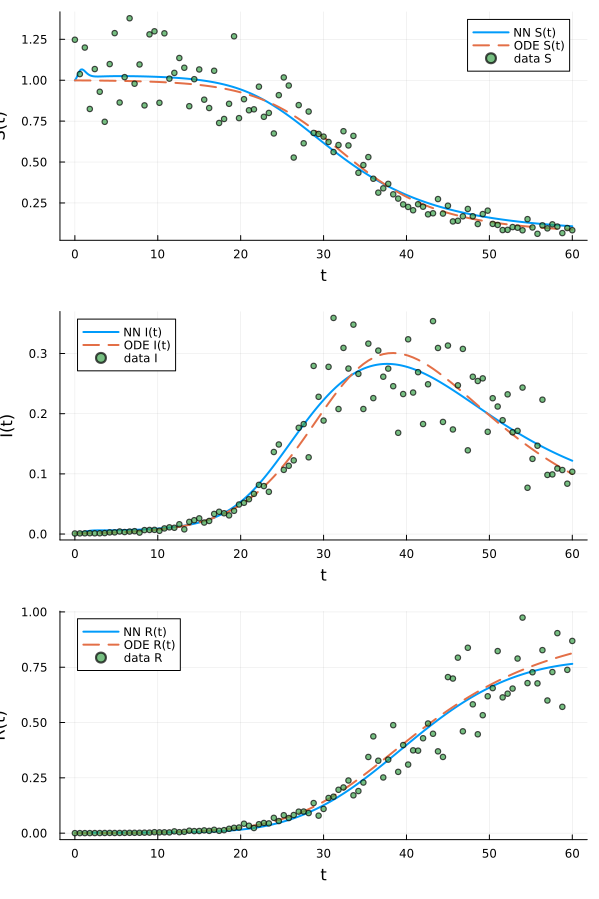

In [7]:
# Build a stateful model bound to the trained params
smodel = Lux.StatefulLuxLayer(State_MLP, ps_trained.StateMLP, st_StateMLP)
#gmodel = Lux.StatefulLuxLayer(g_MLP, ps_trained.gMLP, st_gMLP)

# A smooth time grid for plotting the NN curve
t_plot = Float32.(collect(range(t_span[1], t_span[2], length=400)))

# NN predictions on the smooth grid (3×N)
ŷ_plot = smodel(permutedims(t_plot))  # 1×N input expected; returns 3×N

# Split true, NN, and noisy series
S_true, I_true, R_true = sol_[1, :], sol_[2, :], sol_[3, :]
S_nn,   I_nn,   R_nn   = vec(ŷ_plot[1, :]), vec(ŷ_plot[2, :]), vec(ŷ_plot[3, :])
S_noisy, I_noisy, R_noisy = Y_train[1, :], Y_train[2, :], Y_train[3, :]

# Panel 1: S(t)
p1 = Plots.plot(t_plot, S_nn; label = "NN S(t)", linewidth = 2)
Plots.plot!(p1, t_obs_array, S_true; label = "ODE S(t)", linestyle = :dash, linewidth = 2)
Plots.scatter!(p1, t_train, S_noisy; label = "data S", ms = 3, alpha = 0.7)
Plots.xlabel!(p1, "t")
Plots.ylabel!(p1, "S(t)")

# Panel 2: I(t)
p2 = Plots.plot(t_plot, I_nn; label = "NN I(t)", linewidth = 2)
Plots.plot!(p2, t_obs_array, I_true; label = "ODE I(t)", linestyle = :dash, linewidth = 2)
Plots.scatter!(p2, t_train, I_noisy; label = "data I", ms = 3, alpha = 0.7)
Plots.xlabel!(p2, "t")
Plots.ylabel!(p2, "I(t)")

# Panel 3: R(t)
p3 = Plots.plot(t_plot, R_nn; label = "NN R(t)", linewidth = 2)
Plots.plot!(p3, t_obs_array, R_true; label = "ODE R(t)", linestyle = :dash, linewidth = 2)
Plots.scatter!(p3, t_train, R_noisy; label = "data R", ms = 3, alpha = 0.7)
Plots.xlabel!(p3, "t")
Plots.ylabel!(p3, "R(t)")

# Combine panels
plt = Plots.plot(p1, p2, p3; layout = (3, 1), size = (600, 900))
display(plt)

#Plots.savefig(plt, "Results/2025-10-13_NNfitWithODELoss.svg")


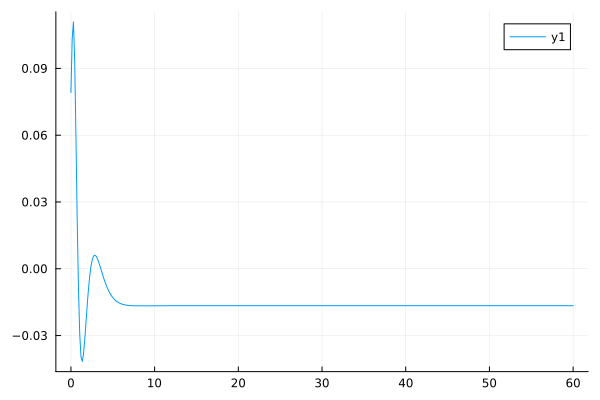

In [23]:
gmodel = Lux.StatefulLuxLayer(g_MLP, ps_trained.gMLP, st_gMLP)

plot(
    t_plot, gmodel(t_plot')'
)

In [20]:
gmodel(t_plot')

1×400 Matrix{Float32}:
 0.0791601  0.103328  0.110855  …  -0.0165882  -0.0165882  -0.0165882

### Symbolic Regression

This will involve using symbolic regression packages to find out symbolic forms of $u(t; \theta_u)$ and $g(t; \theta_g)$

In [ ]:
t_symbolic = Float32.(collect(range(t_span[1], t_span[2], length=1000))')
û_symbolic = smodel(t_symbolic)


dŷ_symbolicdt = reduce(hcat, [Zygote.jacobian(smodel, [τ])[1] for τ in t_symbolic])